Using device: cpu
Using dataset: baby from /kaggle/input/mmdata/data/baby/
Evaluation K values: [5, 10, 20, 50]
Latent Dim: 64, Graph Layers: 2
Transformer Heads: 4, Modal Layers: 2, Fusion Layers: 2
Loading interaction data from: /kaggle/input/mmdata/data/baby/baby.inter
Loaded 160792 interactions.
Interactions after dropping duplicates: 160792
Number of unique users: 19445
Number of unique items: 7050
Loading features from: /kaggle/input/mmdata/data/baby/image_feat.npy
Loaded features with shape: (7050, 4096)
Loading features from: /kaggle/input/mmdata/data/baby/text_feat.npy
Loaded features with shape: (7050, 384)
Building interaction graph...
Interaction graph built.
Normalizing interaction graph...
Graph normalized.
Data loading took: 1.42s

--- Configuring Modalities for Fusion Mode: early_fusion ---
Early Fusion: Using Fusion Transformer and a single Prediction MLP.

--- Training Early-Fusion ---
Epoch 1/20 [263.42s] - BPR Loss: 0.6772 (Reg: 0.0023), Final R@20: 0.0186, N@20: 0.

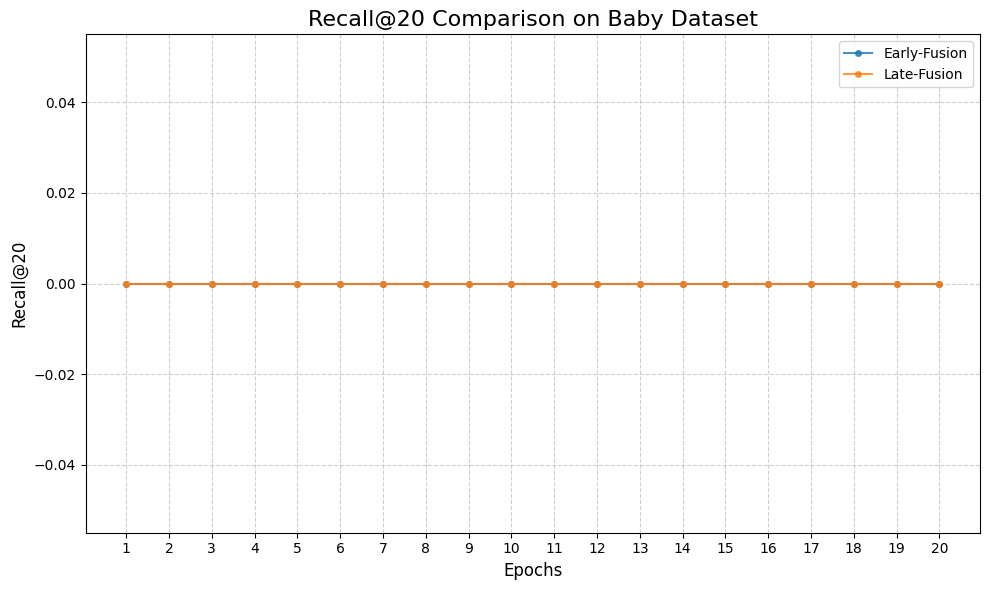

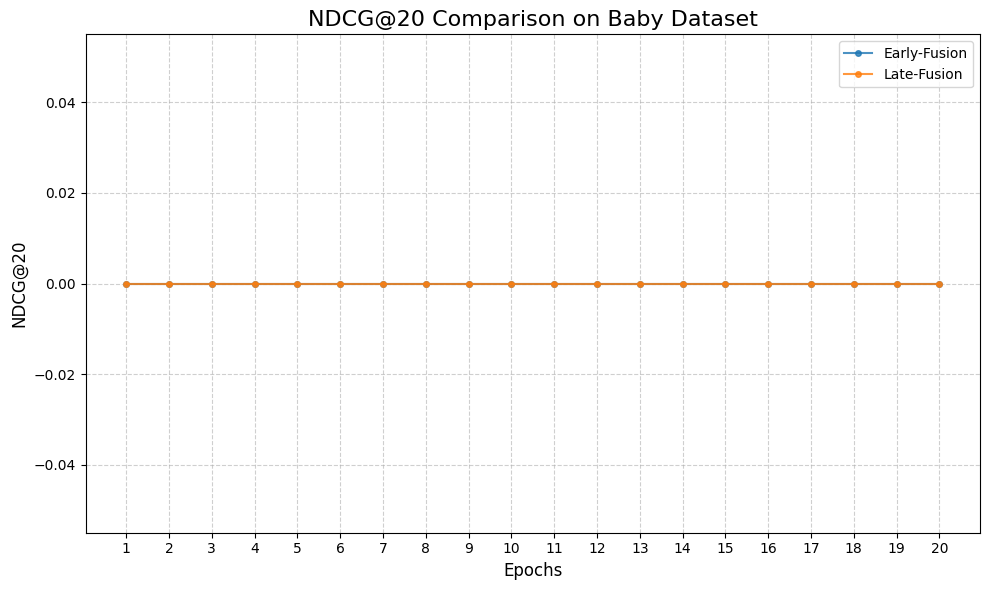


Total script execution time: 9327.63 seconds
Object `code` not found.


In [1]:
# %%
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import time
import random
import math # Added for ndcg_at_k
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score # For AUC
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import scipy.sparse as sp
import matplotlib.pyplot as plt

# For memory usage
import psutil

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Global Time and Memory Tracking ---
script_start_time = time.time()
process = psutil.Process(os.getpid())
peak_memory_usage = 0 # Bytes

def update_peak_memory():
    global peak_memory_usage
    current_memory = process.memory_info().rss
    peak_memory_usage = max(peak_memory_usage, current_memory)

update_peak_memory() # Initial memory

# %%
# --- Configuration ---

DATASET_NAME = 'baby'
DATA_DIR = '/kaggle/input/mmdata/data/baby/'  # Ensure your data files are here or update the path.
EPOCHS = 20

INTER_FILE = f'{DATASET_NAME}.inter'
IMAGE_FEAT_FILE = 'image_feat.npy'
TEXT_FEAT_FILE = 'text_feat.npy'

LATENT_DIM = 64
N_LAYERS = 2 # Graph propagation layers
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4 # For BPR regularization term calculation
BATCH_SIZE = 2048


# Transformer Parameters
TRANSFORMER_NHEAD = 4
MODAL_TRANSFORMER_NLAYERS = 2 # Layers for individual image/text transformers
FUSION_TRANSFORMER_NLAYERS = 2 # Layers for the fusion transformer
TRANSFORMER_DIM_FEEDFORWARD = 128 # Hidden dim in transformer feedforward

# Evaluation Parameters
K_VALUES_FOR_EVAL = [5, 10, 20, 50]
TOP_K_DISPLAY = 20 # For concise epoch logging, one of K_VALUES_FOR_EVAL

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Using dataset: {DATASET_NAME} from {DATA_DIR}")
print(f"Evaluation K values: {K_VALUES_FOR_EVAL}")
print(f"Latent Dim: {LATENT_DIM}, Graph Layers: {N_LAYERS}")
print(f"Transformer Heads: {TRANSFORMER_NHEAD}, Modal Layers: {MODAL_TRANSFORMER_NLAYERS}, Fusion Layers: {FUSION_TRANSFORMER_NLAYERS}")

# %%
# --- Data Loading and Preprocessing ---

def load_interaction_data(data_dir, inter_file_basename):
    file_path = os.path.join(data_dir, inter_file_basename)
    print(f"Loading interaction data from: {file_path}")
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Interaction file not found at {file_path}")
    
    try:
        inter_df = pd.read_csv(
            file_path, sep='\t', header=0,
            usecols=['userID', 'itemID'],
        )
    except Exception as e:
        print(f"Error reading interaction file {file_path}: {e}")
        raise ValueError(f"Could not read {file_path}") from e

    print(f"Loaded {len(inter_df)} interactions.")
    inter_df = inter_df.drop_duplicates(subset=['userID', 'itemID']).reset_index(drop=True)
    print(f"Interactions after dropping duplicates: {len(inter_df)}")

    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    inter_df['user_idx'] = user_encoder.fit_transform(inter_df['userID'])
    inter_df['item_idx'] = item_encoder.fit_transform(inter_df['itemID'])

    n_users = inter_df['user_idx'].nunique()
    n_items = inter_df['item_idx'].nunique()
    print(f"Number of unique users: {n_users}")
    print(f"Number of unique items: {n_items}")
    
    item_id_to_idx = {original_id: idx for idx, original_id in enumerate(item_encoder.classes_)}
    
    return inter_df[['user_idx', 'item_idx']], n_users, n_items, user_encoder, item_encoder, item_id_to_idx

def load_features(data_dir, feat_file_basename, n_items, item_encoder, item_id_to_idx_map):
    file_path = os.path.join(data_dir, feat_file_basename)
    print(f"Loading features from: {file_path}")
    if not os.path.exists(file_path):
        print(f"Warning: Feature file not found at {file_path}. Returning None.")
        return None
    try:
        features_npy = np.load(file_path)
        if features_npy.shape[0] != n_items:
            print(f"Warning: Feature file {feat_file_basename} has a shape mismatch. Returning None.")
            return None

        print(f"Loaded features with shape: {features_npy.shape}")
        return torch.tensor(features_npy, dtype=torch.float).to(DEVICE)
    except Exception as e:
        print(f"Error loading or processing features from {file_path}: {e}")
        return None

def build_interaction_graph(inter_df, n_users, n_items):
    print("Building interaction graph...")
    rows = inter_df['user_idx'].values
    cols = inter_df['item_idx'].values + n_users
    data = np.ones(len(rows))
    adj_mat = sp.coo_matrix((data, (rows, cols)), shape=(n_users + n_items, n_users + n_items), dtype=np.float32)
    adj_mat = adj_mat + adj_mat.T
    adj_mat = adj_mat.tocsr()
    print("Interaction graph built.")
    return adj_mat

def normalize_graph_mat(adj_mat):
    print("Normalizing interaction graph...")
    rowsum = np.array(adj_mat.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    norm_adj_mat = d_mat_inv_sqrt.dot(adj_mat).dot(d_mat_inv_sqrt).tocsr()
    print("Graph normalized.")
    return norm_adj_mat

def scipy_sparse_mat_to_torch_sparse_tensor(sparse_mat):
    sparse_mat = sparse_mat.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mat.row, sparse_mat.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mat.data)
    shape = torch.Size(sparse_mat.shape)
    return torch.sparse_coo_tensor(indices, values, shape, device=DEVICE)

update_peak_memory()

# %%
# --- PyTorch Dataset for BPR Training ---
class BPRDataset(Dataset):
    def __init__(self, interactions_df, n_items):
        self.user_item_pairs = interactions_df[['user_idx', 'item_idx']].values
        self.n_items = n_items
        self.user_item_map = self._build_user_item_map(interactions_df)

    def _build_user_item_map(self, interactions_df):
        return interactions_df.groupby('user_idx')['item_idx'].apply(set).to_dict()

    def __len__(self):
        return len(self.user_item_pairs)

    def __getitem__(self, idx):
        user_idx, pos_item_idx = self.user_item_pairs[idx]
        user_pos_items = self.user_item_map.get(user_idx, set())
        while True:
            neg_item_idx = random.randint(0, self.n_items - 1)
            if neg_item_idx not in user_pos_items:
                break
        return torch.tensor(user_idx), torch.tensor(pos_item_idx), torch.tensor(neg_item_idx)

# %%
# --- Model Definition (NEW MODULAR CLASS) ---

class PredictionMLP(nn.Module):
    """A simple 2-layer MLP for prediction."""
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, in_dim // 2),
            nn.ReLU(),
            nn.Linear(in_dim // 2, out_dim)
        )
        # Initialize weights
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.layers(x).squeeze(-1)


class FusionModel(nn.Module):
    def __init__(self, n_users, n_items, latent_dim, n_layers_graph, adj_mat,
                 image_features=None, text_features=None,
                 fusion_mode='id_only', # 'id_only', 'early_fusion', 'late_fusion'
                 transformer_nhead=4, modal_transformer_nlayers=2,
                 fusion_transformer_nlayers=2, transformer_dim_feedforward=128):
        super().__init__()
        self.n_users, self.n_items = n_users, n_items
        self.latent_dim = latent_dim
        self.n_layers_graph = n_layers_graph
        self.adj_mat = adj_mat
        self.fusion_mode = fusion_mode

        # --- Base Embeddings ---
        self.embedding_user = nn.Embedding(n_users, latent_dim)
        self.embedding_item = nn.Embedding(n_items, latent_dim)
        nn.init.xavier_uniform_(self.embedding_user.weight)
        nn.init.xavier_uniform_(self.embedding_item.weight)

        # --- Modality Processing Layers ---
        self.image_features_raw = image_features.to(DEVICE) if image_features is not None else None
        self.text_features_raw = text_features.to(DEVICE) if text_features is not None else None
        
        self.img_feat_proj, self.image_transformer_encoder = None, None
        self.txt_feat_proj, self.text_transformer_encoder = None, None
        self.fusion_transformer_encoder = None

        has_img = self.image_features_raw is not None
        has_txt = self.text_features_raw is not None
        
        if self.fusion_mode != 'id_only' and (has_img or has_txt):
            print(f"\n--- Configuring Modalities for Fusion Mode: {self.fusion_mode} ---")
            if has_img:
                self.img_feat_proj = nn.Linear(self.image_features_raw.shape[1], latent_dim).to(DEVICE)
                modal_enc_img = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=transformer_nhead, dim_feedforward=transformer_dim_feedforward, batch_first=True, device=DEVICE, dropout=0.1)
                self.image_transformer_encoder = nn.TransformerEncoder(modal_enc_img, num_layers=modal_transformer_nlayers).to(DEVICE)
            if has_txt:
                self.txt_feat_proj = nn.Linear(self.text_features_raw.shape[1], latent_dim).to(DEVICE)
                modal_enc_txt = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=transformer_nhead, dim_feedforward=transformer_dim_feedforward, batch_first=True, device=DEVICE, dropout=0.1)
                self.text_transformer_encoder = nn.TransformerEncoder(modal_enc_txt, num_layers=modal_transformer_nlayers).to(DEVICE)
            
            # --- Fusion Specific Layers ---
            if self.fusion_mode == 'early_fusion':
                fusion_enc_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=transformer_nhead, dim_feedforward=transformer_dim_feedforward, batch_first=True, device=DEVICE, dropout=0.1)
                self.fusion_transformer_encoder = nn.TransformerEncoder(fusion_enc_layer, num_layers=fusion_transformer_nlayers).to(DEVICE)
                self.prediction_mlp = PredictionMLP(latent_dim)
                print("Early Fusion: Using Fusion Transformer and a single Prediction MLP.")

            elif self.fusion_mode == 'late_fusion':
                self.mlp_image = PredictionMLP(latent_dim)
                self.mlp_text = PredictionMLP(latent_dim)
                print("Late Fusion: Using separate MLPs for image and text modalities.")
        else:
            print("\n--- Using ID Embeddings Only ---")
            self.fusion_mode = 'id_only' # Fallback if no features

    def _process_modality(self, raw_features, proj_layer, transformer_encoder):
        """Helper to project and transform a single modality."""
        if raw_features is None or proj_layer is None or transformer_encoder is None:
            return None
        proj = proj_layer(raw_features).unsqueeze(1) # (N_items, 1, D)
        return transformer_encoder(proj).squeeze(1) # (N_items, D)

    def get_propagated_embeddings(self):
        """Performs graph propagation on ID embeddings."""
        user_embeds_0 = self.embedding_user.weight
        item_embeds_0 = self.embedding_item.weight
        all_embeds_0 = torch.cat([user_embeds_0, item_embeds_0], dim=0)
        
        embeddings_list = [all_embeds_0]
        current_embeds = all_embeds_0
        for _ in range(self.n_layers_graph):
            current_embeds = torch.sparse.mm(self.adj_mat, current_embeds)
            embeddings_list.append(current_embeds)
            
        final_embeddings = torch.mean(torch.stack(embeddings_list, dim=0), dim=0)
        return torch.split(final_embeddings, [self.n_users, self.n_items], dim=0)

    def calculate_scores(self, user_embeds, item_indices):
        """Calculates prediction scores based on the fusion mode."""
        item_id_embeds = self.embedding_item(item_indices)
        
        if self.fusion_mode == 'id_only':
            return torch.sum(user_embeds * item_id_embeds, dim=1)
        
        img_item_embeds = self._process_modality(self.image_features_raw[item_indices], self.img_feat_proj, self.image_transformer_encoder)
        txt_item_embeds = self._process_modality(self.text_features_raw[item_indices], self.txt_feat_proj, self.text_transformer_encoder)

        if self.fusion_mode == 'early_fusion':
            fusion_inputs = [item_id_embeds]
            if img_item_embeds is not None: fusion_inputs.append(img_item_embeds)
            if txt_item_embeds is not None: fusion_inputs.append(txt_item_embeds)
            
            stacked_features = torch.stack(fusion_inputs, dim=1) # (Batch, SeqLen, D)
            fused_sequence = self.fusion_transformer_encoder(stacked_features)
            fused_item_embeds = fused_sequence.mean(dim=1)
            return self.prediction_mlp(user_embeds * fused_item_embeds)

        elif self.fusion_mode == 'late_fusion':
            score = 0
            if img_item_embeds is not None:
                # Combine behavior (user) + item ID + image feature
                img_fused_embed = user_embeds * (item_id_embeds + img_item_embeds)
                score += self.mlp_image(img_fused_embed)
            if txt_item_embeds is not None:
                # Combine behavior (user) + item ID + text feature
                txt_fused_embed = user_embeds * (item_id_embeds + txt_item_embeds)
                score += self.mlp_text(txt_fused_embed)
            return score
        
        # Fallback to ID-only if mode is unrecognized
        return torch.sum(user_embeds * item_id_embeds, dim=1)

    def bpr_loss(self, users, pos_items, neg_items):
        final_user_embeds, _ = self.get_propagated_embeddings()
        
        user_embs = final_user_embeds[users]
        pos_scores = self.calculate_scores(user_embs, pos_items)
        neg_scores = self.calculate_scores(user_embs, neg_items)
        
        loss = -torch.mean(F.logsigmoid(pos_scores - neg_scores))
        
        # Regularization on base embeddings
        reg_loss_sum = (self.embedding_user(users).norm(2).pow(2) +
                        self.embedding_item(pos_items).norm(2).pow(2) +
                        self.embedding_item(neg_items).norm(2).pow(2)) / 2.0
        
        return loss, reg_loss_sum

# %%
# --- Evaluation Metrics ---
def precision_at_k(recommendations, ground_truth_items_set, k):
    if not ground_truth_items_set: return 0
    hits = len(set(recommendations[:k]) & ground_truth_items_set)
    return hits / k

def recall_at_k(recommendations, ground_truth_items_set, k):
    if not ground_truth_items_set: return 0
    hits = len(set(recommendations[:k]) & ground_truth_items_set)
    return hits / len(ground_truth_items_set)

def ndcg_at_k(recommendations, ground_truth_items_set, k):
    if not ground_truth_items_set: return 0
    dcg = sum(1.0 / math.log2(i + 2) for i, item in enumerate(recommendations[:k]) if item in ground_truth_items_set)
    idcg = sum(1.0 / math.log2(i + 2) for i in range(min(len(ground_truth_items_set), k)))
    return dcg / idcg if idcg > 0 else 0

def get_auc(scores, pos_items, neg_items_pool):
    pos_scores = scores[pos_items].numpy()
    num_neg_samples = min(len(neg_items_pool), len(pos_items) * 20)
    if num_neg_samples == 0: return 0.5
    
    neg_items = random.sample(neg_items_pool, num_neg_samples)
    neg_scores = scores[neg_items].numpy()
    
    labels = [1] * len(pos_scores) + [0] * len(neg_scores)
    all_scores = np.concatenate([pos_scores, neg_scores])
    
    return roc_auc_score(labels, all_scores) if len(set(labels)) > 1 else 0.5


# --- Evaluation & Training Loop (NEW) ---
@torch.no_grad()
def evaluate_model(model, test_user_item_map, train_user_item_map, n_items, k_values, eval_batch_size=512):
    model.eval()
    
    # Get propagated user embeddings once
    final_user_embeds, _ = model.get_propagated_embeddings()
    
    # Pre-calculate all modality-specific item embeddings
    item_id_embeds_all = model.embedding_item.weight
    img_item_embeds_all = model._process_modality(model.image_features_raw, model.img_feat_proj, model.image_transformer_encoder)
    txt_item_embeds_all = model._process_modality(model.text_features_raw, model.txt_feat_proj, model.text_transformer_encoder)

    results = {
        'final': {f'{m}@{k}': [] for k in k_values for m in ['P', 'R', 'N']} | {'AUC': []},
        'image': {f'{m}@{k}': [] for k in k_values for m in ['P', 'R', 'N']} | {'AUC': []},
        'text': {f'{m}@{k}': [] for k in k_values for m in ['P', 'R', 'N']} | {'AUC': []},
    }
    
    test_users = list(test_user_item_map.keys())
    max_k = max(k_values)

    for i in range(0, len(test_users), eval_batch_size):
        batch_user_indices = test_users[i : i + eval_batch_size]
        batch_user_embeds = final_user_embeds[torch.tensor(batch_user_indices, device=DEVICE)]

        # --- Calculate Scores for Each Modality Combination ---
        scores = {'final': None, 'image': None, 'text': None}

        if model.fusion_mode == 'id_only':
            scores['final'] = torch.matmul(batch_user_embeds, item_id_embeds_all.t())
        elif model.fusion_mode == 'early_fusion':
            # 1. Final (ID + Img + Txt)
            fusion_inputs = [item_id_embeds_all]
            if img_item_embeds_all is not None: fusion_inputs.append(img_item_embeds_all)
            if txt_item_embeds_all is not None: fusion_inputs.append(txt_item_embeds_all)
            fused_item_embeds = model.fusion_transformer_encoder(torch.stack(fusion_inputs, dim=1)).mean(dim=1)
            scores['final'] = model.prediction_mlp(batch_user_embeds.unsqueeze(1) * fused_item_embeds).squeeze()

            # 2. Image-only (ID + Img)
            if img_item_embeds_all is not None:
                fused_item_embeds_img = model.fusion_transformer_encoder(torch.stack([item_id_embeds_all, img_item_embeds_all], dim=1)).mean(dim=1)
                scores['image'] = model.prediction_mlp(batch_user_embeds.unsqueeze(1) * fused_item_embeds_img).squeeze()

            # 3. Text-only (ID + Txt)
            if txt_item_embeds_all is not None:
                fused_item_embeds_txt = model.fusion_transformer_encoder(torch.stack([item_id_embeds_all, txt_item_embeds_all], dim=1)).mean(dim=1)
                scores['text'] = model.prediction_mlp(batch_user_embeds.unsqueeze(1) * fused_item_embeds_txt).squeeze()
                
        elif model.fusion_mode == 'late_fusion':
            if img_item_embeds_all is not None:
                scores['image'] = model.mlp_image(batch_user_embeds.unsqueeze(1) * (item_id_embeds_all + img_item_embeds_all)).squeeze()
            if txt_item_embeds_all is not None:
                scores['text'] = model.mlp_text(batch_user_embeds.unsqueeze(1) * (item_id_embeds_all + txt_item_embeds_all)).squeeze()
            
            # Final score is the sum
            final_score = torch.zeros_like(scores['image'] if scores['image'] is not None else scores['text'])
            if scores['image'] is not None: final_score += scores['image']
            if scores['text'] is not None: final_score += scores['text']
            scores['final'] = final_score

        # --- Evaluate Each Score Matrix ---
        for mode in ['final', 'image', 'text']:
            if scores[mode] is None: continue
            batch_scores_cpu = scores[mode].cpu()

            for j, user_idx in enumerate(batch_user_indices):
                user_scores = batch_scores_cpu[j]
                train_items = train_user_item_map.get(user_idx, set())
                user_scores[list(train_items)] = -np.inf
                
                top_k_indices = torch.topk(user_scores, max_k).indices.tolist()
                gt_items = test_user_item_map.get(user_idx, set())
                if not gt_items: continue

                for k in k_values:
                    results[mode][f'P@{k}'].append(precision_at_k(top_k_indices, gt_items, k))
                    results[mode][f'R@{k}'].append(recall_at_k(top_k_indices, gt_items, k))
                    results[mode][f'N@{k}'].append(ndcg_at_k(top_k_indices, gt_items, k))
                
                neg_pool = list(set(range(n_items)) - train_items - gt_items)
                results[mode]['AUC'].append(get_auc(user_scores, list(gt_items), neg_pool))

    # Average metrics
    avg_results = {}
    for mode, metrics in results.items():
        avg_results[mode] = {k: np.mean(v) if v else 0.0 for k, v in metrics.items()}

    update_peak_memory()
    return avg_results


def train_epoch(model, optimizer, train_loader, weight_decay_val):
    model.train()
    total_bpr_loss, total_reg_loss, total_batches = 0.0, 0.0, len(train_loader)
    if total_batches == 0: return 0.0, 0.0

    for users, pos_items, neg_items in train_loader:
        users, pos_items, neg_items = users.to(DEVICE), pos_items.to(DEVICE), neg_items.to(DEVICE)
        optimizer.zero_grad()
        bpr_loss, reg_loss_sum = model.bpr_loss(users, pos_items, neg_items)
        
        explicit_reg_loss = weight_decay_val * reg_loss_sum 
        loss = bpr_loss + explicit_reg_loss
        
        loss.backward()
        optimizer.step()
        
        total_bpr_loss += bpr_loss.item()
        total_reg_loss += explicit_reg_loss.item()

    update_peak_memory()
    return total_bpr_loss / total_batches, total_reg_loss / total_batches


def run_training(model_name, model, optimizer, train_loader, test_map, train_map, n_items, epochs, wd_bpr, k_values_eval, k_display):
    print(f"\n--- Training {model_name} ---")
    
    history = {'final': [], 'image': [], 'text': []}
    best_metric_val = 0.0
    training_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()
        bpr_l, reg_l = train_epoch(model, optimizer, train_loader, wd_bpr)
        eval_metrics = evaluate_model(model, test_map, train_map, n_items, k_values_eval)
        epoch_dur = time.time() - epoch_start_time

        # Store history
        for mode in ['final', 'image', 'text']:
            history[mode].append(eval_metrics.get(mode, {}))

        final_metrics = eval_metrics.get('final', {})
        recall_val = final_metrics.get(f'R@{k_display}', 0)
        ndcg_val = final_metrics.get(f'N@{k_display}', 0)
        auc_val = final_metrics.get('AUC', 0)
        
        print(f"Epoch {epoch+1}/{epochs} [{epoch_dur:.2f}s] - BPR Loss: {bpr_l:.4f} (Reg: {reg_l:.4f}), "
              f"Final R@{k_display}: {recall_val:.4f}, N@{k_display}: {ndcg_val:.4f}, AUC: {auc_val:.4f}")

        if recall_val > best_metric_val:
            best_metric_val = recall_val

    total_training_time = time.time() - training_start_time
    print(f"--- Finished Training {model_name} in {total_training_time:.2f}s (Best Final R@{k_display}: {best_metric_val:.4f}) ---")
    update_peak_memory()
    return history, total_training_time

# %%
# --- Plotting Function ---
def plot_comparison_metrics(histories, metric_to_plot, dataset_name):
    """
    Plots a single metric (e.g., 'Recall@20') for all trained models.
    """
    plt.figure(figsize=(10, 6))
    
    for model_name, history in histories.items():
        # history['final'] is a list of dictionaries, one for each epoch
        final_metrics_per_epoch = history.get('final', [])
        if not final_metrics_per_epoch:
            continue

        epochs = range(1, len(final_metrics_per_epoch) + 1)
        metric_values = [epoch_data.get(metric_to_plot, 0) for epoch_data in final_metrics_per_epoch]
        
        if metric_values:
            plt.plot(epochs, metric_values, label=f'{model_name}', marker='o', ms=4, alpha=0.8)

    plt.title(f'{metric_to_plot} Comparison on {dataset_name.capitalize()} Dataset', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel(metric_to_plot, fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(np.arange(1, len(epochs) + 1, 1)) # Ensure integer ticks for epochs
    plt.tight_layout()
    plt.show()

# %%
# --- Main Execution ---
if __name__ == '__main__':
    # --- Data Loading ---
    data_load_start_time = time.time()
    try:
        interactions, n_users, n_items, _, item_enc, item_id_map = load_interaction_data(DATA_DIR, INTER_FILE)
        img_features = load_features(DATA_DIR, IMAGE_FEAT_FILE, n_items, item_enc, item_id_map)
        txt_features = load_features(DATA_DIR, TEXT_FEAT_FILE, n_items, item_enc, item_id_map)
        interaction_graph = build_interaction_graph(interactions, n_users, n_items)
        norm_interaction_graph = normalize_graph_mat(interaction_graph)
        graph_tensor = scipy_sparse_mat_to_torch_sparse_tensor(norm_interaction_graph)
        data_loaded_successfully = True
    except (FileNotFoundError, ValueError) as e:
        print(f"\nCritical Error during data loading: {e}")
        data_loaded_successfully = False
    
    if data_loaded_successfully:
        print(f"Data loading took: {time.time() - data_load_start_time:.2f}s")
        # --- Data Splitting ---
        user_counts = interactions['user_idx'].value_counts()
        valid_users = user_counts[user_counts >= 2].index
        stratify_df = interactions[interactions['user_idx'].isin(valid_users)]
        train_inter, test_inter = train_test_split(stratify_df, test_size=0.2, stratify=stratify_df['user_idx'], random_state=SEED)
        
        train_user_item_map = train_inter.groupby('user_idx')['item_idx'].apply(set).to_dict()
        test_user_item_map = test_inter.groupby('user_idx')['item_idx'].apply(set).to_dict()
        
        train_dataset = BPRDataset(train_inter, n_items)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

        # --- Model Definitions ---
        # MODIFIED: This dictionary now only contains the Late-Fusion and Early-Fusion models
        model_configs = {
            "Early-Fusion": {"fusion_mode": "early_fusion"},
            "Late-Fusion": {"fusion_mode": "late_fusion"}
        }
        all_histories = {}
        all_train_times = {}

        for name, config in model_configs.items():
            model = FusionModel(
                n_users, n_items, LATENT_DIM, N_LAYERS, graph_tensor,
                image_features=img_features, text_features=txt_features,
                transformer_nhead=TRANSFORMER_NHEAD,
                modal_transformer_nlayers=MODAL_TRANSFORMER_NLAYERS,
                fusion_transformer_nlayers=FUSION_TRANSFORMER_NLAYERS,
                transformer_dim_feedforward=TRANSFORMER_DIM_FEEDFORWARD,
                **config
            ).to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
            
            history, train_time = run_training(
                name, model, optimizer, train_loader, test_user_item_map,
                train_user_item_map, n_items, EPOCHS, WEIGHT_DECAY,
                K_VALUES_FOR_EVAL, TOP_K_DISPLAY
            )
            all_histories[name] = history
            all_train_times[name] = train_time

        # --- Final Results Analysis ---
        print("\n\n--- Final Model Comparison (Last Epoch) ---")
        header_parts = ["Model", "Component"] + [f"R@{k}" for k in K_VALUES_FOR_EVAL] + [f"N@{k}" for k in K_VALUES_FOR_EVAL] + ["AUC"]
        col_widths = [15, 10] + [7] * (len(K_VALUES_FOR_EVAL) * 2 + 1)
        header_str = " | ".join([f"{h:<{col_widths[i]}}" for i, h in enumerate(header_parts)])
        print(header_str)
        print("-" * len(header_str))

        def format_row(model_name, component, metrics, widths):
            row_data = [f"{model_name:<{widths[0]}}", f"{component:<{widths[1]}}"]
            current_idx = 2
            for k in K_VALUES_FOR_EVAL:
                row_data.append(f"{metrics.get(f'R@{k}', 0):.4f}".ljust(widths[current_idx]))
                current_idx += 1
            for k in K_VALUES_FOR_EVAL:
                row_data.append(f"{metrics.get(f'N@{k}', 0):.4f}".ljust(widths[current_idx]))
                current_idx += 1
            row_data.append(f"{metrics.get('AUC', 0):.4f}".ljust(widths[current_idx]))
            print(" | ".join(row_data))

        for name, history in all_histories.items():
            is_first = True
            for component in ['final', 'image', 'text']:
                # Ensure history for the component is not empty before accessing the last element
                if history.get(component) and history[component][-1]:
                    last_epoch_metrics = history[component][-1]
                    model_display_name = name if is_first else ""
                    format_row(model_display_name, f"({component})", last_epoch_metrics, col_widths)
                    is_first = False
            print("-" * len(header_str))

        # ADDED: Plotting for specific metrics
        if all_histories:
            print("\n--- Plotting Comparison Metrics ---")
            plot_comparison_metrics(all_histories, 'Recall@20', DATASET_NAME)
            plot_comparison_metrics(all_histories, 'NDCG@20', DATASET_NAME)


    # --- Final script summary ---
    script_end_time = time.time()
    total_script_time = script_end_time - script_start_time
    print(f"\nTotal script execution time: {total_script_time:.2f} seconds")
    print(f"Peak memory usage: {peak_memory_usage / (1024**2):.2f} MB") what is the summary of the given code?